In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.preprocessing.image
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import sklearn.linear_model
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import os;
import datetime  
import cv2 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm  
%matplotlib inline

/home/jupyter/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jupyter/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jupyter/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jupyter/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

In [4]:
print(os.path.dirname(os.getcwd())+':', os.listdir(os.path.dirname(os.getcwd())));
print(os.getcwd()+':', os.listdir(os.getcwd()));

/home/jupyter/kaggle_comp: ['.ipynb_checkpoints', 'House Prices Advanced Regression Techniques', '.git', 'digit_recognition']
/home/jupyter/kaggle_comp/digit_recognition: ['.ipynb_checkpoints', 'digit_recognition.ipynb', 'data']


In [6]:
if os.path.isfile('data/train.csv'):
    df_train = pd.read_csv('data/train.csv')
    print('train.csv loaded: df_train({0[0]}, {0[1]})'.format(df_train.shape))
else:
    print('Error: train.csv not found')

train.csv loaded: df_train(42000, 785)


In [7]:
print(df_train.isnull().any().describe())

count       785
unique        1
top       False
freq        785
dtype: object


In [9]:
df_train.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

In [10]:
print('distinct labels ', df_train['label'].unique())

distinct labels  [1 0 4 7 3 5 8 9 2 6]


## normalize data and split into training and validation sets

x_train_valid.shape =  (42000, 28, 28, 1)
y_train_valid_labels.shape =  (42000,)
image_size =  784
image_width =  28
image_height =  28
labels_count =  10


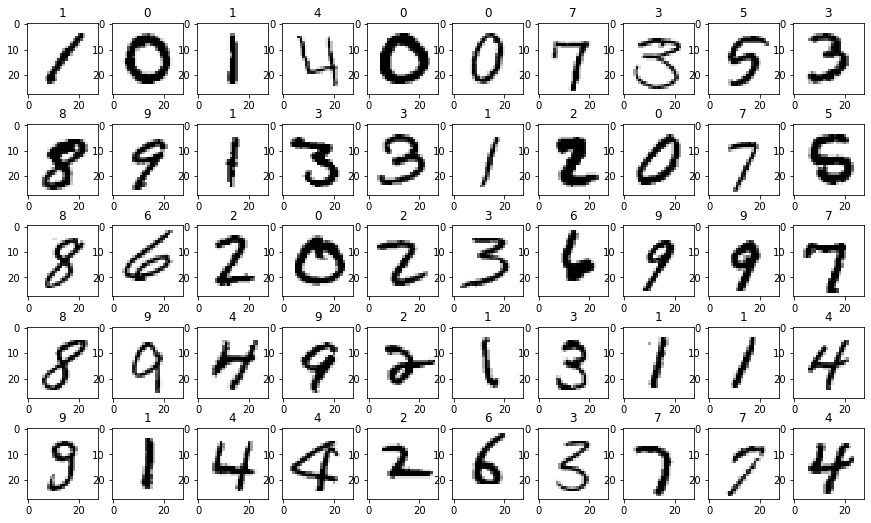

In [12]:
# function to normalize data
def normalize_data(data): 
    # scale features using statistics that are robust to outliers
    #rs = sklearn.preprocessing.RobustScaler()
    #rs.fit(data)
    #data = rs.transform(data)
    #data = (data-data.mean())/(data.std()) # standardisation
    data = data / data.max() # convert from [0:255] to [0.:1.]
    #data = ((data / 255.)-0.5)*2. # convert from [0:255] to [-1.:+1.]
    return data

# convert class labels from scalars to one-hot vectors e.g. 1 => [0 1 0 0 0 0 0 0 0 0]
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

# convert one-hot encodings into labels
def one_hot_to_dense(labels_one_hot):
    return np.argmax(labels_one_hot,1)

# computet the accuracy of label predictions
def accuracy_from_dense_labels(y_target, y_pred):
    y_target = y_target.reshape(-1,)
    y_pred = y_pred.reshape(-1,)
    return np.mean(y_target == y_pred)

# computet the accuracy of one-hot encoded predictions
def accuracy_from_one_hot_labels(y_target, y_pred):
    y_target = one_hot_to_dense(y_target).reshape(-1,)
    y_pred = one_hot_to_dense(y_pred).reshape(-1,)
    return np.mean(y_target == y_pred)

# extract and normalize images
x_train_valid = df_train.iloc[:,1:].values.reshape(-1,28,28,1) # (42000,28,28,1) array
x_train_valid = x_train_valid.astype(np.float) # convert from int64 to float32
x_train_valid = normalize_data(x_train_valid)
image_width = image_height = 28
image_size = 784

# extract image labels
y_train_valid_labels = df_train.iloc[:,0].values # (42000,1) array
labels_count = np.unique(y_train_valid_labels).shape[0]; # number of different labels = 10

#plot some images and labels
plt.figure(figsize=(15,9))
for i in range(50):
    plt.subplot(5,10,1+i)
    plt.title(y_train_valid_labels[i])
    plt.imshow(x_train_valid[i].reshape(28,28), cmap=cm.binary)
    
# labels in one hot representation
y_train_valid = dense_to_one_hot(y_train_valid_labels, labels_count).astype(np.uint8)

# dictionaries for saving results
y_valid_pred = {}
y_train_pred = {}
y_test_pred = {}
train_loss, valid_loss = {}, {}
train_acc, valid_acc = {}, {}

print('x_train_valid.shape = ', x_train_valid.shape)
print('y_train_valid_labels.shape = ', y_train_valid_labels.shape)
print('image_size = ', image_size )
print('image_width = ', image_width)
print('image_height = ', image_height)
print('labels_count = ', labels_count)

## augment data

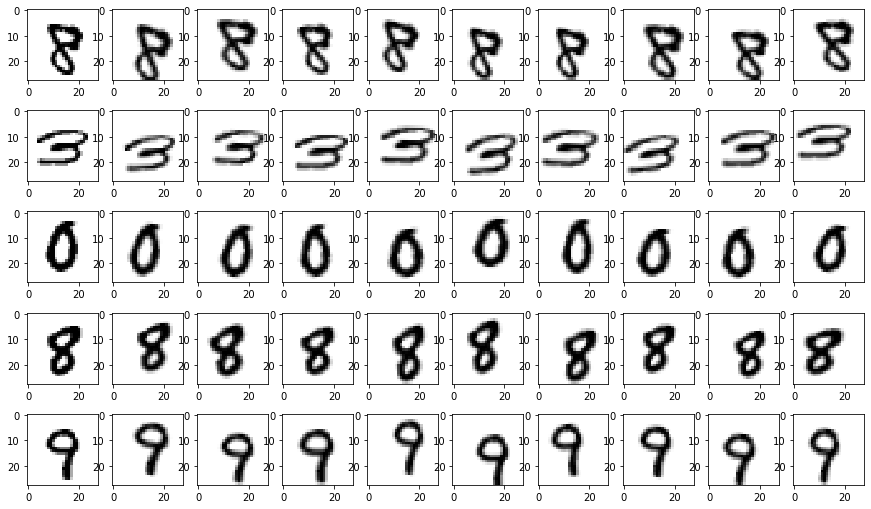

In [13]:

# generate new images via rotations, translations, zoom using keras
def generate_images(imgs):
    
    # rotations, translations, zoom
    image_generator = keras.preprocessing.image.ImageDataGenerator(
        rotation_range = 10, width_shift_range = 0.1 , height_shift_range = 0.1,
        zoom_range = 0.1)

    # get transformed images
    imgs = image_generator.flow(imgs.copy(), np.zeros(len(imgs)),
                                batch_size=len(imgs), shuffle = False).next()    
  
    return imgs[0]

# check image generation
fig,axs = plt.subplots(5,10, figsize=(15,9))
for i in range(5):
    n = np.random.randint(0,x_train_valid.shape[0]-2)
    axs[i,0].imshow(x_train_valid[n:n+1].reshape(28,28),cmap=cm.binary)
    axs[i,1].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,2].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,3].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,4].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,5].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,6].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,7].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,8].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,9].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)

## First try out some basic sklearn models

In [14]:
logreg = sklearn.linear_model.LogisticRegression(verbose=0, solver='lbfgs',
                                                 multi_class='multinomial')
decision_tree = sklearn.tree.DecisionTreeClassifier()
extra_trees = sklearn.ensemble.ExtraTreesClassifier(verbose=0)
gradient_boost = sklearn.ensemble.GradientBoostingClassifier(verbose=0)
random_forest = sklearn.ensemble.RandomForestClassifier(verbose=0)
gaussianNB = sklearn.naive_bayes.GaussianNB()

# store models in dictionary
base_models = {'logreg': logreg, 'extra_trees': extra_trees,
               'gradient_boost': gradient_boost, 'random_forest': random_forest, 
               'decision_tree': decision_tree, 'gaussianNB': gaussianNB}

# choose models for out-of-folds predictions
take_models = ['logreg','random_forest','extra_trees']

for mn in take_models:
    train_acc[mn] = []
    valid_acc[mn] = []

# cross validations
cv_num = 10 # cross validations default = 20 => 5% validation set
kfold = sklearn.model_selection.KFold(cv_num, shuffle=True, random_state=123)

for i,(train_index, valid_index) in enumerate(kfold.split(x_train_valid)):

    # start timer
    start = datetime.datetime.now();

    # train and validation data of original images
    x_train = x_train_valid[train_index].reshape(-1,784)
    y_train = y_train_valid[train_index]
    x_valid = x_train_valid[valid_index].reshape(-1,784)
    y_valid = y_train_valid[valid_index]

    for mn in take_models:

        # create cloned model from base models
        model = sklearn.base.clone(base_models[mn])
        model.fit(x_train, one_hot_to_dense(y_train))

        # predictions
        y_train_pred[mn] = model.predict_proba(x_train)
        y_valid_pred[mn] = model.predict_proba(x_valid)
        train_acc[mn].append(accuracy_from_one_hot_labels(y_train_pred[mn], y_train))
        valid_acc[mn].append(accuracy_from_one_hot_labels(y_valid_pred[mn], y_valid))

        print(i,': '+mn+' train/valid accuracy = %.3f/%.3f'%(train_acc[mn][-1], 
                                                             valid_acc[mn][-1]))
    # only one iteration
    if False:
        break;

print(mn+': averaged train/valid accuracy = %.3f/%.3f'%(np.mean(train_acc[mn]),
                                                        np.mean(valid_acc[mn])))

/home/jupyter/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/jupyter/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0 : logreg train/valid accuracy = 0.940/0.920
0 : random_forest train/valid accuracy = 0.999/0.941


/home/jupyter/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0 : extra_trees train/valid accuracy = 1.000/0.944


/home/jupyter/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/jupyter/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1 : logreg train/valid accuracy = 0.940/0.921
1 : random_forest train/valid accuracy = 0.999/0.941


/home/jupyter/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1 : extra_trees train/valid accuracy = 1.000/0.949


/home/jupyter/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/jupyter/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


2 : logreg train/valid accuracy = 0.939/0.929
2 : random_forest train/valid accuracy = 0.999/0.945


/home/jupyter/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


2 : extra_trees train/valid accuracy = 1.000/0.948


/home/jupyter/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/jupyter/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


3 : logreg train/valid accuracy = 0.939/0.925
3 : random_forest train/valid accuracy = 0.999/0.940


/home/jupyter/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


3 : extra_trees train/valid accuracy = 1.000/0.947


/home/jupyter/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/jupyter/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


4 : logreg train/valid accuracy = 0.940/0.921
4 : random_forest train/valid accuracy = 0.999/0.937


/home/jupyter/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


4 : extra_trees train/valid accuracy = 1.000/0.946


/home/jupyter/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/jupyter/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


5 : logreg train/valid accuracy = 0.939/0.918
5 : random_forest train/valid accuracy = 0.999/0.939


/home/jupyter/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


5 : extra_trees train/valid accuracy = 1.000/0.944


/home/jupyter/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/jupyter/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


6 : logreg train/valid accuracy = 0.941/0.916
6 : random_forest train/valid accuracy = 0.999/0.942


/home/jupyter/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


6 : extra_trees train/valid accuracy = 1.000/0.944


/home/jupyter/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/jupyter/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


7 : logreg train/valid accuracy = 0.941/0.912
7 : random_forest train/valid accuracy = 0.999/0.938


/home/jupyter/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


7 : extra_trees train/valid accuracy = 1.000/0.945


/home/jupyter/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/jupyter/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


8 : logreg train/valid accuracy = 0.940/0.925
8 : random_forest train/valid accuracy = 0.999/0.946


/home/jupyter/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


8 : extra_trees train/valid accuracy = 1.000/0.945


/home/jupyter/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/jupyter/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


9 : logreg train/valid accuracy = 0.940/0.918
9 : random_forest train/valid accuracy = 0.999/0.935


/home/jupyter/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


9 : extra_trees train/valid accuracy = 1.000/0.944
extra_trees: averaged train/valid accuracy = 1.000/0.946


## compare accuracies of base models

logreg averaged train/valid accuracy = 0.940/0.920
random_forest averaged train/valid accuracy = 0.999/0.940
extra_trees averaged train/valid accuracy = 1.000/0.946


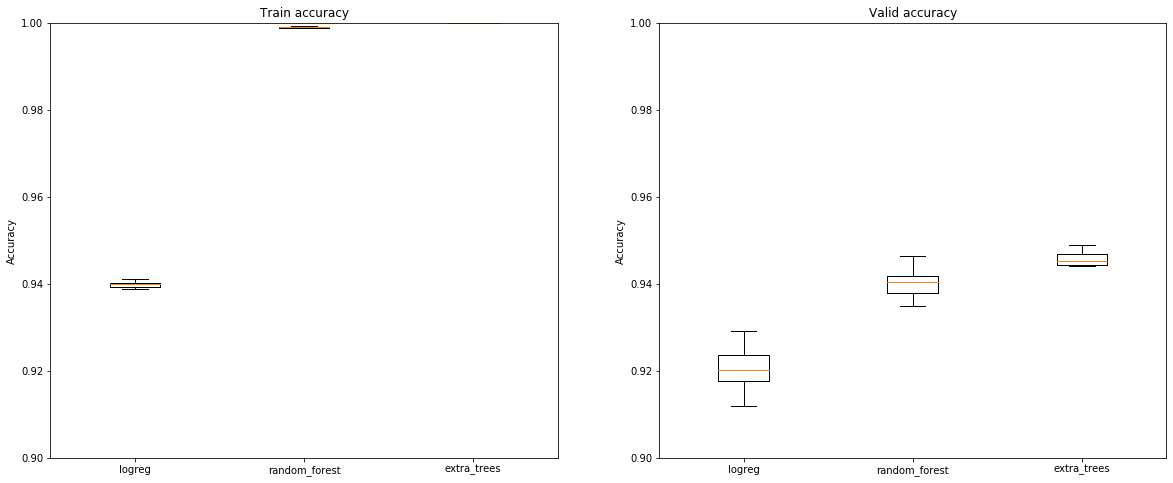

In [15]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,2,1)
plt.title('Train accuracy')
plt.boxplot([train_acc[mn] for mn in train_acc.keys()])
ax.set_xticklabels([mn for mn in train_acc.keys()])
ax.set_ylabel('Accuracy');
ax.set_ylim([0.90,1.0])

ax = fig.add_subplot(1,2,2)
plt.title('Valid accuracy')
plt.boxplot([valid_acc[mn] for mn in train_acc.keys()])
ax.set_xticklabels([mn for mn in train_acc.keys()])
ax.set_ylabel('Accuracy');
ax.set_ylim([0.90,1.0])

for mn in train_acc.keys():
    print(mn + ' averaged train/valid accuracy = %.3f/%.3f'%(np.mean(train_acc[mn]),
                                                             np.mean(valid_acc[mn])))

## build the neural network class

In [16]:
class nn_class:
# class that implements the neural network

    # constructor
    def __init__(self, nn_name = 'nn_1'):

        # tunable hyperparameters for nn architecture
        self.s_f_conv1 = 3; # filter size of first convolution layer (default = 3)
        self.n_f_conv1 = 36; # number of features of first convolution layer (default = 36)
        self.s_f_conv2 = 3; # filter size of second convolution layer (default = 3)
        self.n_f_conv2 = 36; # number of features of second convolution layer (default = 36)
        self.s_f_conv3 = 3; # filter size of third convolution layer (default = 3)
        self.n_f_conv3 = 36; # number of features of third convolution layer (default = 36)
        self.n_n_fc1 = 576; # number of neurons of first fully connected layer (default = 576)

        # tunable hyperparameters for training
        self.mb_size = 50 # mini batch size
        self.keep_prob = 0.33 # keeping probability with dropout regularization 
        self.learn_rate_array = [10*1e-4, 7.5*1e-4, 5*1e-4, 2.5*1e-4, 1*1e-4, 1*1e-4,
                                 1*1e-4,0.75*1e-4, 0.5*1e-4, 0.25*1e-4, 0.1*1e-4, 
                                 0.1*1e-4, 0.075*1e-4,0.050*1e-4, 0.025*1e-4, 0.01*1e-4, 
                                 0.0075*1e-4, 0.0050*1e-4,0.0025*1e-4,0.001*1e-4]
        self.learn_rate_step_size = 3 # in terms of epochs
        
        # parameters
        self.learn_rate = self.learn_rate_array[0]
        self.learn_rate_pos = 0 # current position pointing to current learning rate
        self.index_in_epoch = 0 
        self.current_epoch = 0
        self.log_step = 0.2 # log results in terms of epochs
        self.n_log_step = 0 # counting current number of mini batches trained on
        self.use_tb_summary = False # True = use tensorboard visualization
        self.use_tf_saver = False # True = use saver to save the model
        self.nn_name = nn_name # name of the neural network
        
        # permutation array
        self.perm_array = np.array([])
        
    # function to get the next mini batch
    def next_mini_batch(self):

        start = self.index_in_epoch
        self.index_in_epoch += self.mb_size
        self.current_epoch += self.mb_size/len(self.x_train)  
        
        # adapt length of permutation array
        if not len(self.perm_array) == len(self.x_train):
            self.perm_array = np.arange(len(self.x_train))
        
        # shuffle once at the start of epoch
        if start == 0:
            np.random.shuffle(self.perm_array)

        # at the end of the epoch
        if self.index_in_epoch > self.x_train.shape[0]:
            np.random.shuffle(self.perm_array) # shuffle data
            start = 0 # start next epoch
            self.index_in_epoch = self.mb_size # set index to mini batch size
            
            if self.train_on_augmented_data:
                # use augmented data for the next epoch
                self.x_train_aug = normalize_data(self.generate_images(self.x_train))
                self.y_train_aug = self.y_train
                
        end = self.index_in_epoch
        
        if self.train_on_augmented_data:
            # use augmented data
            x_tr = self.x_train_aug[self.perm_array[start:end]]
            y_tr = self.y_train_aug[self.perm_array[start:end]]
        else:
            # use original data
            x_tr = self.x_train[self.perm_array[start:end]]
            y_tr = self.y_train[self.perm_array[start:end]]
        
        return x_tr, y_tr
               
    # generate new images via rotations, translations, zoom using keras
    def generate_images(self, imgs):
    
        print('generate new set of images')
        
        # rotations, translations, zoom
        image_generator = keras.preprocessing.image.ImageDataGenerator(
            rotation_range = 10, width_shift_range = 0.1 , height_shift_range = 0.1,
            zoom_range = 0.1)

        # get transformed images
        imgs = image_generator.flow(imgs.copy(), np.zeros(len(imgs)),
                                    batch_size=len(imgs), shuffle = False).next()    

        return imgs[0]

    # weight initialization
    def weight_variable(self, shape, name = None):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial, name = name)

    # bias initialization
    def bias_variable(self, shape, name = None):
        initial = tf.constant(0.1, shape=shape) #  positive bias
        return tf.Variable(initial, name = name)

    # 2D convolution
    def conv2d(self, x, W, name = None):
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name = name)

    # max pooling
    def max_pool_2x2(self, x, name = None):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                              padding='SAME', name = name)

    # attach summaries to a tensor for TensorBoard visualization
    def summary_variable(self, var, var_name):
        with tf.name_scope(var_name):
            mean = tf.reduce_mean(var)
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
            tf.summary.scalar('mean', mean)
            tf.summary.scalar('stddev', stddev)
            tf.summary.scalar('max', tf.reduce_max(var))
            tf.summary.scalar('min', tf.reduce_min(var))
            tf.summary.histogram('histogram', var)
    
    # function to create the graph
    def create_graph(self):

        # reset default graph
        tf.reset_default_graph()

        # variables for input and output 
        self.x_data_tf = tf.placeholder(dtype=tf.float32, shape=[None,28,28,1], 
                                        name='x_data_tf')
        self.y_data_tf = tf.placeholder(dtype=tf.float32, shape=[None,10], name='y_data_tf')

        # 1.layer: convolution + max pooling
        self.W_conv1_tf = self.weight_variable([self.s_f_conv1, self.s_f_conv1, 1,
                                                self.n_f_conv1], 
                                               name = 'W_conv1_tf') # (5,5,1,32)
        self.b_conv1_tf = self.bias_variable([self.n_f_conv1], name = 'b_conv1_tf') # (32)
        self.h_conv1_tf = tf.nn.relu(self.conv2d(self.x_data_tf, 
                                                 self.W_conv1_tf) + self.b_conv1_tf, 
                                     name = 'h_conv1_tf') # (.,28,28,32)
        self.h_pool1_tf = self.max_pool_2x2(self.h_conv1_tf, 
                                            name = 'h_pool1_tf') # (.,14,14,32)

        # 2.layer: convolution + max pooling
        self.W_conv2_tf = self.weight_variable([self.s_f_conv2, self.s_f_conv2, 
                                                self.n_f_conv1, self.n_f_conv2], 
                                               name = 'W_conv2_tf')
        self.b_conv2_tf = self.bias_variable([self.n_f_conv2], name = 'b_conv2_tf')
        self.h_conv2_tf = tf.nn.relu(self.conv2d(self.h_pool1_tf, 
                                                 self.W_conv2_tf) + self.b_conv2_tf, 
                                     name ='h_conv2_tf') #(.,14,14,32)
        self.h_pool2_tf = self.max_pool_2x2(self.h_conv2_tf, name = 'h_pool2_tf') #(.,7,7,32)

        # 3.layer: convolution + max pooling
        self.W_conv3_tf = self.weight_variable([self.s_f_conv3, self.s_f_conv3, 
                                                self.n_f_conv2, self.n_f_conv3], 
                                               name = 'W_conv3_tf')
        self.b_conv3_tf = self.bias_variable([self.n_f_conv3], name = 'b_conv3_tf')
        self.h_conv3_tf = tf.nn.relu(self.conv2d(self.h_pool2_tf, 
                                                 self.W_conv3_tf) + self.b_conv3_tf, 
                                     name = 'h_conv3_tf') #(.,7,7,32)
        self.h_pool3_tf = self.max_pool_2x2(self.h_conv3_tf, 
                                            name = 'h_pool3_tf') # (.,4,4,32)

        # 4.layer: fully connected
        self.W_fc1_tf = self.weight_variable([4*4*self.n_f_conv3,self.n_n_fc1], 
                                             name = 'W_fc1_tf') # (4*4*32, 1024)
        self.b_fc1_tf = self.bias_variable([self.n_n_fc1], name = 'b_fc1_tf') # (1024)
        self.h_pool3_flat_tf = tf.reshape(self.h_pool3_tf, [-1,4*4*self.n_f_conv3], 
                                          name = 'h_pool3_flat_tf') # (.,1024)
        self.h_fc1_tf = tf.nn.relu(tf.matmul(self.h_pool3_flat_tf, 
                                             self.W_fc1_tf) + self.b_fc1_tf, 
                                   name = 'h_fc1_tf') # (.,1024)
      
        # add dropout
        self.keep_prob_tf = tf.placeholder(dtype=tf.float32, name = 'keep_prob_tf')
        self.h_fc1_drop_tf = tf.nn.dropout(self.h_fc1_tf, self.keep_prob_tf, 
                                           name = 'h_fc1_drop_tf')

        # 5.layer: fully connected
        self.W_fc2_tf = self.weight_variable([self.n_n_fc1, 10], name = 'W_fc2_tf')
        self.b_fc2_tf = self.bias_variable([10], name = 'b_fc2_tf')
        self.z_pred_tf = tf.add(tf.matmul(self.h_fc1_drop_tf, self.W_fc2_tf), 
                                self.b_fc2_tf, name = 'z_pred_tf')# => (.,10)

        # cost function
        self.cross_entropy_tf = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            labels=self.y_data_tf, logits=self.z_pred_tf), name = 'cross_entropy_tf')
     
        # optimisation function
        self.learn_rate_tf = tf.placeholder(dtype=tf.float32, name="learn_rate_tf")
        self.train_step_tf = tf.train.AdamOptimizer(self.learn_rate_tf).minimize(
            self.cross_entropy_tf, name = 'train_step_tf')

        # predicted probabilities in one-hot encoding
        self.y_pred_proba_tf = tf.nn.softmax(self.z_pred_tf, name='y_pred_proba_tf') 
        
        # tensor of correct predictions
        self.y_pred_correct_tf = tf.equal(tf.argmax(self.y_pred_proba_tf, 1),
                                          tf.argmax(self.y_data_tf, 1),
                                          name = 'y_pred_correct_tf')  
        
        # accuracy 
        self.accuracy_tf = tf.reduce_mean(tf.cast(self.y_pred_correct_tf, dtype=tf.float32),
                                         name = 'accuracy_tf')

        # tensors to save intermediate accuracies and losses during training
        self.train_loss_tf = tf.Variable(np.array([]), dtype=tf.float32, 
                                         name='train_loss_tf', validate_shape = False)
        self.valid_loss_tf = tf.Variable(np.array([]), dtype=tf.float32, 
                                         name='valid_loss_tf', validate_shape = False)
        self.train_acc_tf = tf.Variable(np.array([]), dtype=tf.float32, 
                                        name='train_acc_tf', validate_shape = False)
        self.valid_acc_tf = tf.Variable(np.array([]), dtype=tf.float32, 
                                        name='valid_acc_tf', validate_shape = False)
     
        # number of weights and biases
        num_weights = (self.s_f_conv1**2*self.n_f_conv1 
                       + self.s_f_conv2**2*self.n_f_conv1*self.n_f_conv2 
                       + self.s_f_conv3**2*self.n_f_conv2*self.n_f_conv3 
                       + 4*4*self.n_f_conv3*self.n_n_fc1 + self.n_n_fc1*10)
        num_biases = self.n_f_conv1 + self.n_f_conv2 + self.n_f_conv3 + self.n_n_fc1
        print('num_weights =', num_weights)
        print('num_biases =', num_biases)
        
        return None  
    
    def attach_summary(self, sess):
        
        # create summary tensors for tensorboard
        self.use_tb_summary = True
        self.summary_variable(self.W_conv1_tf, 'W_conv1_tf')
        self.summary_variable(self.b_conv1_tf, 'b_conv1_tf')
        self.summary_variable(self.W_conv2_tf, 'W_conv2_tf')
        self.summary_variable(self.b_conv2_tf, 'b_conv2_tf')
        self.summary_variable(self.W_conv3_tf, 'W_conv3_tf')
        self.summary_variable(self.b_conv3_tf, 'b_conv3_tf')
        self.summary_variable(self.W_fc1_tf, 'W_fc1_tf')
        self.summary_variable(self.b_fc1_tf, 'b_fc1_tf')
        self.summary_variable(self.W_fc2_tf, 'W_fc2_tf')
        self.summary_variable(self.b_fc2_tf, 'b_fc2_tf')
        tf.summary.scalar('cross_entropy_tf', self.cross_entropy_tf)
        tf.summary.scalar('accuracy_tf', self.accuracy_tf)

        # merge all summaries for tensorboard
        self.merged = tf.summary.merge_all()

        # initialize summary writer 
        timestamp = datetime.datetime.now().strftime('%d-%m-%Y_%H-%M-%S')
        filepath = os.path.join(os.getcwd(), 'logs', (self.nn_name+'_'+timestamp))
        self.train_writer = tf.summary.FileWriter(os.path.join(filepath,'train'), sess.graph)
        self.valid_writer = tf.summary.FileWriter(os.path.join(filepath,'valid'), sess.graph)

    def attach_saver(self):
        # initialize tensorflow saver
        self.use_tf_saver = True
        self.saver_tf = tf.train.Saver()

    # function to train the graph
    def train_graph(self, sess, x_train, y_train, x_valid, y_valid, n_epoch = 1, 
                    train_on_augmented_data = False):

        # train on original or augmented data
        self.train_on_augmented_data = train_on_augmented_data
        
        # training and validation data
        self.x_train = x_train
        self.y_train = y_train
        self.x_valid = x_valid
        self.y_valid = y_valid
        
        # use augmented data
        if self.train_on_augmented_data:
            print('generate new set of images')
            self.x_train_aug = normalize_data(self.generate_images(self.x_train))
            self.y_train_aug = self.y_train
        
        # parameters
        mb_per_epoch = self.x_train.shape[0]/self.mb_size
        train_loss, train_acc, valid_loss, valid_acc = [],[],[],[]
        
        # start timer
        start = datetime.datetime.now();
        print(datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'),': start training')
        print('learnrate = ',self.learn_rate,', n_epoch = ', n_epoch,
              ', mb_size = ', self.mb_size)
        # looping over mini batches
        for i in range(int(n_epoch*mb_per_epoch)+1):

            # adapt learn_rate
            self.learn_rate_pos = int(self.current_epoch // self.learn_rate_step_size)
            if not self.learn_rate == self.learn_rate_array[self.learn_rate_pos]:
                self.learn_rate = self.learn_rate_array[self.learn_rate_pos]
                print(datetime.datetime.now()-start,': set learn rate to %.6f'%self.learn_rate)
            
            # get new batch
            x_batch, y_batch = self.next_mini_batch() 

            # run the graph
            sess.run(self.train_step_tf, feed_dict={self.x_data_tf: x_batch, 
                                                    self.y_data_tf: y_batch, 
                                                    self.keep_prob_tf: self.keep_prob, 
                                                    self.learn_rate_tf: self.learn_rate})
             
            
            # store losses and accuracies
            if i%int(self.log_step*mb_per_epoch) == 0 or i == int(n_epoch*mb_per_epoch):
             
                self.n_log_step += 1 # for logging the results
                
                feed_dict_train = {
                    self.x_data_tf: self.x_train[self.perm_array[:len(self.x_valid)]], 
                    self.y_data_tf: self.y_train[self.perm_array[:len(self.y_valid)]], 
                    self.keep_prob_tf: 1.0}
                
                feed_dict_valid = {self.x_data_tf: self.x_valid, 
                                   self.y_data_tf: self.y_valid, 
                                   self.keep_prob_tf: 1.0}
                
                # summary for tensorboard
                if self.use_tb_summary:
                    train_summary = sess.run(self.merged, feed_dict = feed_dict_train)
                    valid_summary = sess.run(self.merged, feed_dict = feed_dict_valid)
                    self.train_writer.add_summary(train_summary, self.n_log_step)
                    self.valid_writer.add_summary(valid_summary, self.n_log_step)
                
                train_loss.append(sess.run(self.cross_entropy_tf,
                                           feed_dict = feed_dict_train))

                train_acc.append(self.accuracy_tf.eval(session = sess, 
                                                       feed_dict = feed_dict_train))
                
                valid_loss.append(sess.run(self.cross_entropy_tf,
                                           feed_dict = feed_dict_valid))

                valid_acc.append(self.accuracy_tf.eval(session = sess, 
                                                       feed_dict = feed_dict_valid))

                print('%.2f epoch: train/val loss = %.4f/%.4f, train/val acc = %.4f/%.4f'%(
                    self.current_epoch, train_loss[-1], valid_loss[-1],
                    train_acc[-1], valid_acc[-1]))
     
        # concatenate losses and accuracies and assign to tensor variables
        tl_c = np.concatenate([self.train_loss_tf.eval(session=sess), train_loss], axis = 0)
        vl_c = np.concatenate([self.valid_loss_tf.eval(session=sess), valid_loss], axis = 0)
        ta_c = np.concatenate([self.train_acc_tf.eval(session=sess), train_acc], axis = 0)
        va_c = np.concatenate([self.valid_acc_tf.eval(session=sess), valid_acc], axis = 0)
   
        sess.run(tf.assign(self.train_loss_tf, tl_c, validate_shape = False))
        sess.run(tf.assign(self.valid_loss_tf, vl_c , validate_shape = False))
        sess.run(tf.assign(self.train_acc_tf, ta_c , validate_shape = False))
        sess.run(tf.assign(self.valid_acc_tf, va_c , validate_shape = False))
        
        print('running time for training: ', datetime.datetime.now() - start)
        return None
  
    # save tensors/summaries
    def save_model(self, sess):
        
        # tf saver
        if self.use_tf_saver:
            #filepath = os.path.join(os.getcwd(), 'logs' , self.nn_name)
            filepath = os.path.join(os.getcwd(), self.nn_name)
            self.saver_tf.save(sess, filepath)
        
        # tb summary
        if self.use_tb_summary:
            self.train_writer.close()
            self.valid_writer.close()
        
        return None
  
    # forward prediction of current graph
    def forward(self, sess, x_data):
        y_pred_proba = self.y_pred_proba_tf.eval(session = sess, 
                                                 feed_dict = {self.x_data_tf: x_data,
                                                              self.keep_prob_tf: 1.0})
        return y_pred_proba
    
    # function to load tensors from a saved graph
    def load_tensors(self, graph):
        
        # input tensors
        self.x_data_tf = graph.get_tensor_by_name("x_data_tf:0")
        self.y_data_tf = graph.get_tensor_by_name("y_data_tf:0")
        
        # weights and bias tensors
        self.W_conv1_tf = graph.get_tensor_by_name("W_conv1_tf:0")
        self.W_conv2_tf = graph.get_tensor_by_name("W_conv2_tf:0")
        self.W_conv3_tf = graph.get_tensor_by_name("W_conv3_tf:0")
        self.W_fc1_tf = graph.get_tensor_by_name("W_fc1_tf:0")
        self.W_fc2_tf = graph.get_tensor_by_name("W_fc2_tf:0")
        self.b_conv1_tf = graph.get_tensor_by_name("b_conv1_tf:0")
        self.b_conv2_tf = graph.get_tensor_by_name("b_conv2_tf:0")
        self.b_conv3_tf = graph.get_tensor_by_name("b_conv3_tf:0")
        self.b_fc1_tf = graph.get_tensor_by_name("b_fc1_tf:0")
        self.b_fc2_tf = graph.get_tensor_by_name("b_fc2_tf:0")
        
        # activation tensors
        self.h_conv1_tf = graph.get_tensor_by_name('h_conv1_tf:0')  
        self.h_pool1_tf = graph.get_tensor_by_name('h_pool1_tf:0')
        self.h_conv2_tf = graph.get_tensor_by_name('h_conv2_tf:0')
        self.h_pool2_tf = graph.get_tensor_by_name('h_pool2_tf:0')
        self.h_conv3_tf = graph.get_tensor_by_name('h_conv3_tf:0')
        self.h_pool3_tf = graph.get_tensor_by_name('h_pool3_tf:0')
        self.h_fc1_tf = graph.get_tensor_by_name('h_fc1_tf:0')
        self.z_pred_tf = graph.get_tensor_by_name('z_pred_tf:0')
        
        # training and prediction tensors
        self.learn_rate_tf = graph.get_tensor_by_name("learn_rate_tf:0")
        self.keep_prob_tf = graph.get_tensor_by_name("keep_prob_tf:0")
        self.cross_entropy_tf = graph.get_tensor_by_name('cross_entropy_tf:0')
        self.train_step_tf = graph.get_operation_by_name('train_step_tf')
        self.z_pred_tf = graph.get_tensor_by_name('z_pred_tf:0')
        self.y_pred_proba_tf = graph.get_tensor_by_name("y_pred_proba_tf:0")
        self.y_pred_correct_tf = graph.get_tensor_by_name('y_pred_correct_tf:0')
        self.accuracy_tf = graph.get_tensor_by_name('accuracy_tf:0')
        
        # tensor of stored losses and accuricies during training
        self.train_loss_tf = graph.get_tensor_by_name("train_loss_tf:0")
        self.train_acc_tf = graph.get_tensor_by_name("train_acc_tf:0")
        self.valid_loss_tf = graph.get_tensor_by_name("valid_loss_tf:0")
        self.valid_acc_tf = graph.get_tensor_by_name("valid_acc_tf:0")
  
        return None
    
    # get losses of training and validation sets
    def get_loss(self, sess):
        train_loss = self.train_loss_tf.eval(session = sess)
        valid_loss = self.valid_loss_tf.eval(session = sess)
        return train_loss, valid_loss 
        
    # get accuracies of training and validation sets
    def get_accuracy(self, sess):
        train_acc = self.train_acc_tf.eval(session = sess)
        valid_acc = self.valid_acc_tf.eval(session = sess)
        return train_acc, valid_acc 
    
    # get weights
    def get_weights(self, sess):
        W_conv1 = self.W_conv1_tf.eval(session = sess)
        W_conv2 = self.W_conv2_tf.eval(session = sess)
        W_conv3 = self.W_conv3_tf.eval(session = sess)
        W_fc1_tf = self.W_fc1_tf.eval(session = sess)
        W_fc2_tf = self.W_fc2_tf.eval(session = sess)
        return W_conv1, W_conv2, W_conv3, W_fc1_tf, W_fc2_tf
    
    # get biases
    def get_biases(self, sess):
        b_conv1 = self.b_conv1_tf.eval(session = sess)
        b_conv2 = self.b_conv2_tf.eval(session = sess)
        b_conv3 = self.b_conv3_tf.eval(session = sess)
        b_fc1_tf = self.b_fc1_tf.eval(session = sess)
        b_fc2_tf = self.b_fc2_tf.eval(session = sess)
        return b_conv1, b_conv2, b_conv3, b_fc1_tf, b_fc2_tf
    
    # load session from file, restore graph, and load tensors
    def load_session_from_file(self, filename):
        tf.reset_default_graph()
        filepath = os.path.join(os.getcwd(), filename + '.meta')
        #filepath = os.path.join(os.getcwd(),'logs', filename + '.meta')
        saver = tf.train.import_meta_graph(filepath)
        print(filepath)
        sess = tf.Session()
        saver.restore(sess, mn)
        graph = tf.get_default_graph()
        self.load_tensors(graph)
        return sess
    
    # receive activations given the input
    def get_activations(self, sess, x_data):
        feed_dict = {self.x_data_tf: x_data, self.keep_prob_tf: 1.0}
        h_conv1 = self.h_conv1_tf.eval(session = sess, feed_dict = feed_dict)
        h_pool1 = self.h_pool1_tf.eval(session = sess, feed_dict = feed_dict)
        h_conv2 = self.h_conv2_tf.eval(session = sess, feed_dict = feed_dict)
        h_pool2 = self.h_pool2_tf.eval(session = sess, feed_dict = feed_dict)
        h_conv3 = self.h_conv3_tf.eval(session = sess, feed_dict = feed_dict)
        h_pool3 = self.h_pool3_tf.eval(session = sess, feed_dict = feed_dict)
        h_fc1 = self.h_fc1_tf.eval(session = sess, feed_dict = feed_dict)
        h_fc2 = self.z_pred_tf.eval(session = sess, feed_dict = feed_dict)
        return h_conv1,h_pool1,h_conv2,h_pool2,h_conv3,h_pool3,h_fc1,h_fc2

## train the neural network graph

In [17]:
nn_name = ['tmp']

# cross validations
cv_num = 10 # cross validations default = 20 => 5% validation set
kfold = sklearn.model_selection.KFold(cv_num, shuffle=True, random_state=123)

for i,(train_index, valid_index) in enumerate(kfold.split(x_train_valid)):
    
    # start timer
    start = datetime.datetime.now();
    
    # train and validation data of original images
    x_train = x_train_valid[train_index]
    y_train = y_train_valid[train_index]
    x_valid = x_train_valid[valid_index]
    y_valid = y_train_valid[valid_index]
    
    # create neural network graph
    nn_graph = nn_class(nn_name = nn_name[i]) # instance of nn_class
    nn_graph.create_graph() # create graph
    nn_graph.attach_saver() # attach saver tensors
    
    # start tensorflow session
    with tf.Session() as sess:
        
        # attach summaries
        nn_graph.attach_summary(sess) 
        
        # variable initialization of the default graph
        sess.run(tf.global_variables_initializer()) 
    
        # training on original data
        nn_graph.train_graph(sess, x_train, y_train, x_valid, y_valid, n_epoch = 1.0)
        
        # training on augmented data
        nn_graph.train_graph(sess, x_train, y_train, x_valid, y_valid, n_epoch = 14.0,
                            train_on_augmented_data = True)

        # save tensors and summaries of model
        nn_graph.save_model(sess)
        
    # only one iteration
    if True:
        break;
        
    
print('total running time for training: ', datetime.datetime.now() - start)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

num_weights = 361188
num_biases = 684
04-10-2019 06:41:15 : start training
learnrate =  0.001 , n_epoch =  1.0 , mb_size =  50
0.00 epoch: train/val loss = 2.5818/2.5763, train/val acc = 0.0990/0.1036
0.20 epoch: train/val loss = 0.2198/0.2377, train/val acc = 0.9381/0.9352
0.40 epoch: train/val loss = 0.1169/0.1287, train/val acc = 0.9633/0.9569
0.60 epoch: train/val loss = 0.1122/0.1176, train/val acc = 0.9633/0.9633
0.80 epoch: train/val loss = 0.0796/0.0900, train/val acc = 0.9752/0.9705
1.00 epoch: train/val loss = 0.0781/0.0780, train/val acc = 0.9767/0.9755
1.00 epoch: train/val loss = 0.0665/0.0788, train/val acc = 0.9805/0.9752
running time for training:  0:01:14.842319
genera

/home/jupyter/kaggle_comp/digit_recognition/tmp.meta
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from tmp


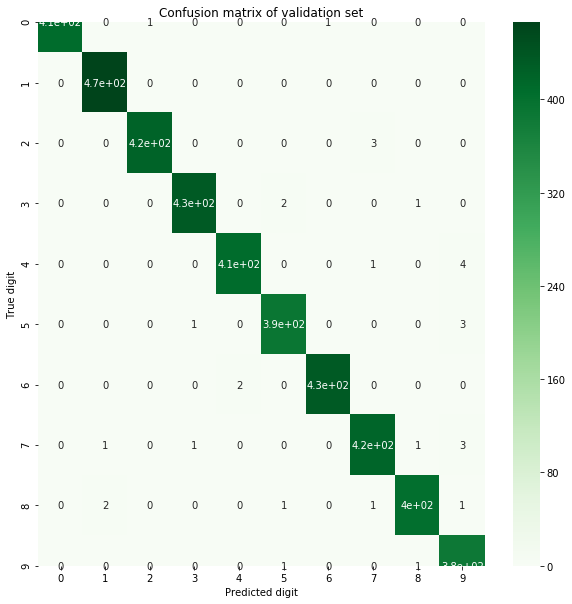

In [18]:
mn = nn_name[0]
nn_graph = nn_class()
sess = nn_graph.load_session_from_file(mn)
y_valid_pred[mn] = nn_graph.forward(sess, x_valid)
sess.close()

cnf_matrix = sklearn.metrics.confusion_matrix(
    one_hot_to_dense(y_valid_pred[mn]), one_hot_to_dense(y_valid)).astype(np.float32)

labels_array = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
fig, ax = plt.subplots(1,figsize=(10,10))
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(labels_array)
ax.set_yticklabels(labels_array)
plt.title('Confusion matrix of validation set')
plt.ylabel('True digit')
plt.xlabel('Predicted digit')
plt.show();

## loss and accuracy curves

/home/jupyter/kaggle_comp/digit_recognition/tmp.meta
INFO:tensorflow:Restoring parameters from tmp
final train/valid loss = 0.0148/0.0216, train/valid accuracy = 0.9943/0.9924


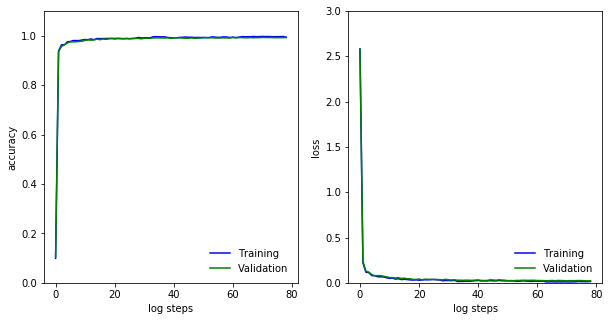

In [19]:
mn = nn_name[0]
nn_graph = nn_class()
sess = nn_graph.load_session_from_file(mn)
train_loss[mn], valid_loss[mn] = nn_graph.get_loss(sess)
train_acc[mn], valid_acc[mn] = nn_graph.get_accuracy(sess)
sess.close()

print('final train/valid loss = %.4f/%.4f, train/valid accuracy = %.4f/%.4f'%(
    train_loss[mn][-1], valid_loss[mn][-1], train_acc[mn][-1], valid_acc[mn][-1]))

plt.figure(figsize=(10, 5));
plt.subplot(1,2,1);
plt.plot(np.arange(0,len(train_acc[mn])), train_acc[mn],'-b', label='Training')
plt.plot(np.arange(0,len(valid_acc[mn])), valid_acc[mn],'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
plt.ylim(ymax = 1.1, ymin = 0.0)
plt.ylabel('accuracy')
plt.xlabel('log steps');

plt.subplot(1,2,2)
plt.plot(np.arange(0,len(train_loss[mn])), train_loss[mn],'-b', label='Training')
plt.plot(np.arange(0,len(valid_loss[mn])), valid_loss[mn],'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
plt.ylim(ymax = 3.0, ymin = 0.0)
plt.ylabel('loss')
plt.xlabel('log steps');

## visualize weights

/home/jupyter/kaggle_comp/digit_recognition/tmp.meta
INFO:tensorflow:Restoring parameters from tmp
W_conv1: min = -0.35256568 max = 0.33737233 mean = -0.0064620594 std = 0.14080872
W_conv2: min = -0.48278686 max = 0.3243938 mean = -0.012726529 std = 0.105213635
W_conv3: min = -0.41841814 max = 0.3490325 mean = -0.017720088 std = 0.108017035


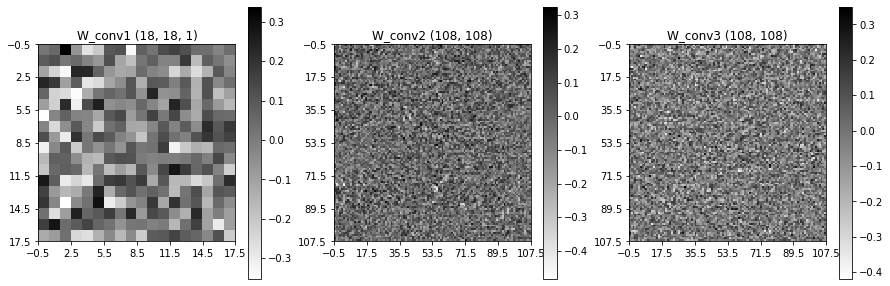

In [20]:
mn = nn_name[0]
nn_graph = nn_class()
sess = nn_graph.load_session_from_file(mn)
W_conv1, W_conv2, W_conv3, _, _ = nn_graph.get_weights(sess)
sess.close()

print('W_conv1: min = ' + str(np.min(W_conv1)) + ' max = ' + str(np.max(W_conv1))
      + ' mean = ' + str(np.mean(W_conv1)) + ' std = ' + str(np.std(W_conv1)))
print('W_conv2: min = ' + str(np.min(W_conv2)) + ' max = ' + str(np.max(W_conv2))
      + ' mean = ' + str(np.mean(W_conv2)) + ' std = ' + str(np.std(W_conv2)))
print('W_conv3: min = ' + str(np.min(W_conv3)) + ' max = ' + str(np.max(W_conv3))
      + ' mean = ' + str(np.mean(W_conv3)) + ' std = ' + str(np.std(W_conv3)))

s_f_conv1 = nn_graph.s_f_conv1
s_f_conv2 = nn_graph.s_f_conv2
s_f_conv3 = nn_graph.s_f_conv3

W_conv1 = np.reshape(W_conv1,(s_f_conv1,s_f_conv1,1,6,6))
W_conv1 = np.transpose(W_conv1,(3,0,4,1,2))
W_conv1 = np.reshape(W_conv1,(s_f_conv1*6,s_f_conv1*6,1))

W_conv2 = np.reshape(W_conv2,(s_f_conv2,s_f_conv2,6,6,36))
W_conv2 = np.transpose(W_conv2,(2,0,3,1,4))
W_conv2 = np.reshape(W_conv2,(6*s_f_conv2,6*s_f_conv2,6,6))
W_conv2 = np.transpose(W_conv2,(2,0,3,1))
W_conv2 = np.reshape(W_conv2,(6*6*s_f_conv2,6*6*s_f_conv2))

W_conv3 = np.reshape(W_conv3,(s_f_conv3,s_f_conv3,6,6,36))
W_conv3 = np.transpose(W_conv3,(2,0,3,1,4))
W_conv3 = np.reshape(W_conv3,(6*s_f_conv3,6*s_f_conv3,6,6))
W_conv3 = np.transpose(W_conv3,(2,0,3,1))
W_conv3 = np.reshape(W_conv3,(6*6*s_f_conv3,6*6*s_f_conv3))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.gca().set_xticks(np.arange(-0.5, s_f_conv1*6, s_f_conv1), minor = False);
plt.gca().set_yticks(np.arange(-0.5, s_f_conv1*6, s_f_conv1), minor = False);
plt.grid(which = 'minor', color='b', linestyle='-', linewidth=1)
plt.title('W_conv1 ' + str(W_conv1.shape))
plt.colorbar(plt.imshow(W_conv1[:,:,0], cmap=cm.binary));

plt.subplot(1,3,2)
plt.gca().set_xticks(np.arange(-0.5, 6*6*s_f_conv2, 6*s_f_conv2), minor = False);
plt.gca().set_yticks(np.arange(-0.5, 6*6*s_f_conv2, 6*s_f_conv2), minor = False);
plt.grid(which = 'minor', color='b', linestyle='-', linewidth=1)
plt.title('W_conv2 ' + str(W_conv2.shape))
plt.colorbar(plt.imshow(W_conv2[:,:], cmap=cm.binary));

plt.subplot(1,3,3)
plt.gca().set_xticks(np.arange(-0.5, 6*6*s_f_conv3, 6*s_f_conv3), minor = False);
plt.gca().set_yticks(np.arange(-0.5, 6*6*s_f_conv3, 6*s_f_conv3), minor = False);
plt.grid(which = 'minor', color='b', linestyle='-', linewidth=1)
plt.title('W_conv3 ' + str(W_conv3.shape))
plt.colorbar(plt.imshow(W_conv3[:,:], cmap=cm.binary));

## visualize activations

/home/jupyter/kaggle_comp/digit_recognition/tmp.meta
INFO:tensorflow:Restoring parameters from tmp
h_fc2 =  [[ -5.72 -12.09  -2.97   0.23 -11.31  -1.72  -3.9  -14.75  18.72  -1.6 ]]


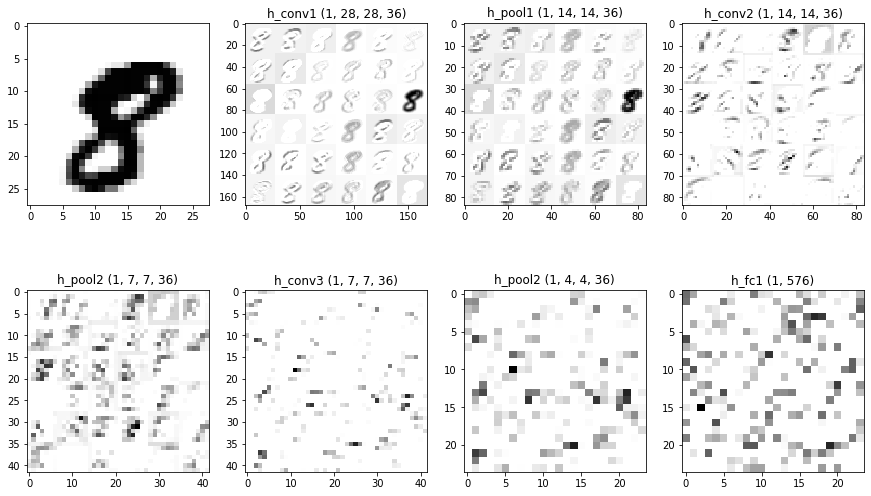

In [21]:
img_no = 10;
mn = nn_name[0]
nn_graph = nn_class()
sess = nn_graph.load_session_from_file(mn)
(h_conv1, h_pool1, h_conv2, h_pool2,h_conv3, h_pool3, h_fc1,
 h_fc2) = nn_graph.get_activations(sess, x_train_valid[img_no:img_no+1])
sess.close()
    
# original image
plt.figure(figsize=(15,9))
plt.subplot(2,4,1)
plt.imshow(x_train_valid[img_no].reshape(28,28),cmap=cm.binary);

# 1. convolution
plt.subplot(2,4,2)
plt.title('h_conv1 ' + str(h_conv1.shape))
h_conv1 = np.reshape(h_conv1,(-1,28,28,6,6))
h_conv1 = np.transpose(h_conv1,(0,3,1,4,2))
h_conv1 = np.reshape(h_conv1,(-1,6*28,6*28))
plt.imshow(h_conv1[0], cmap=cm.binary);

# 1. max pooling
plt.subplot(2,4,3)
plt.title('h_pool1 ' + str(h_pool1.shape))
h_pool1 = np.reshape(h_pool1,(-1,14,14,6,6))
h_pool1 = np.transpose(h_pool1,(0,3,1,4,2))
h_pool1 = np.reshape(h_pool1,(-1,6*14,6*14))
plt.imshow(h_pool1[0], cmap=cm.binary);

# 2. convolution
plt.subplot(2,4,4)
plt.title('h_conv2 ' + str(h_conv2.shape))
h_conv2 = np.reshape(h_conv2,(-1,14,14,6,6))
h_conv2 = np.transpose(h_conv2,(0,3,1,4,2))
h_conv2 = np.reshape(h_conv2,(-1,6*14,6*14))
plt.imshow(h_conv2[0], cmap=cm.binary);

# 2. max pooling
plt.subplot(2,4,5)
plt.title('h_pool2 ' + str(h_pool2.shape))
h_pool2 = np.reshape(h_pool2,(-1,7,7,6,6))
h_pool2 = np.transpose(h_pool2,(0,3,1,4,2))
h_pool2 = np.reshape(h_pool2,(-1,6*7,6*7))
plt.imshow(h_pool2[0], cmap=cm.binary);

# 3. convolution
plt.subplot(2,4,6)
plt.title('h_conv3 ' + str(h_conv3.shape))
h_conv3 = np.reshape(h_conv3,(-1,7,7,6,6))
h_conv3 = np.transpose(h_conv3,(0,3,1,4,2))
h_conv3 = np.reshape(h_conv3,(-1,6*7,6*7))
plt.imshow(h_conv3[0], cmap=cm.binary);

# 3. max pooling
plt.subplot(2,4,7)
plt.title('h_pool2 ' + str(h_pool3.shape))
h_pool3 = np.reshape(h_pool3,(-1,4,4,6,6))
h_pool3 = np.transpose(h_pool3,(0,3,1,4,2))
h_pool3 = np.reshape(h_pool3,(-1,6*4,6*4))
plt.imshow(h_pool3[0], cmap=cm.binary);

# 4. FC layer
plt.subplot(2,4,8)
plt.title('h_fc1 ' + str(h_fc1.shape))
h_fc1 = np.reshape(h_fc1,(-1,24,24))
plt.imshow(h_fc1[0], cmap=cm.binary);

# 5. FC layer
np.set_printoptions(precision=2)
print('h_fc2 = ', h_fc2)


## show misclassified images

/home/jupyter/kaggle_comp/digit_recognition/tmp.meta
INFO:tensorflow:Restoring parameters from tmp
# false predictions:  32 out of 4200


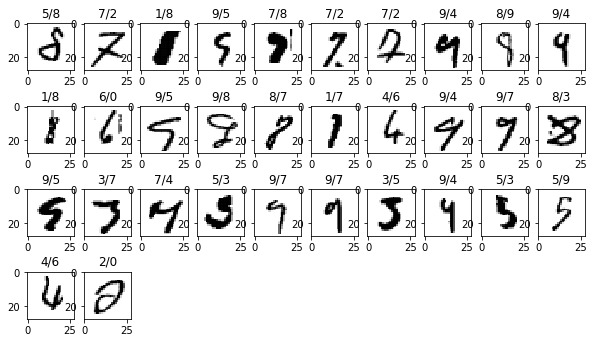

In [22]:
mn = nn_name[0]
nn_graph = nn_class()
sess = nn_graph.load_session_from_file(mn)
y_valid_pred[mn] = nn_graph.forward(sess, x_valid)
sess.close()

y_valid_pred_label = one_hot_to_dense(y_valid_pred[mn])
y_valid_label = one_hot_to_dense(y_valid)
y_val_false_index = []

for i in range(y_valid_label.shape[0]):
    if y_valid_pred_label[i] != y_valid_label[i]:
        y_val_false_index.append(i)

print('# false predictions: ', len(y_val_false_index),'out of', len(y_valid))

plt.figure(figsize=(10,15))
for j in range(0,5):
    for i in range(0,10):
        if j*10+i<len(y_val_false_index):
            plt.subplot(10,10,j*10+i+1)
            plt.title('%d/%d'%(y_valid_label[y_val_false_index[j*10+i]],
                               y_valid_pred_label[y_val_false_index[j*10+i]]))
            plt.imshow(x_valid[y_val_false_index[j*10+i]].reshape(28,28),cmap=cm.binary)

In [23]:
# read test data from CSV file 
if os.path.isfile('../input/test.csv'):
    test_df = pd.read_csv('../input/test.csv') # on kaggle 
    print('test.csv loaded: test_df{0}'.format(test_df.shape))
elif os.path.isfile('data/test.csv'):
    test_df = pd.read_csv('data/test.csv') # on local environment
    print('test.csv loaded: test_df{0}'.format(test_df.shape))
else:
    print('Error: test.csv not found')
    
# transforma and normalize test data
x_test = test_df.iloc[:,0:].values.reshape(-1,28,28,1) # (28000,28,28,1) array
x_test = x_test.astype(np.float)
x_test = normalize_data(x_test)
print('x_test.shape = ', x_test.shape)

# for saving results
y_test_pred = {}
y_test_pred_labels = {}

test.csv loaded: test_df(28000, 784)
x_test.shape =  (28000, 28, 28, 1)


In [25]:
mn = nn_name[0] # choose saved model
nn_graph = nn_class() # create instance
sess = nn_graph.load_session_from_file(mn) # receive session 
y_test_pred = {}
y_test_pred_labels = {}

# split evaluation of test predictions into batches
kfold = sklearn.model_selection.KFold(40, shuffle=False) 
for i,(train_index, valid_index) in enumerate(kfold.split(x_test)):
    if i==0:
        y_test_pred[mn] = nn_graph.forward(sess, x_test[valid_index])
    else: 
        y_test_pred[mn] = np.concatenate([y_test_pred[mn],
                                              nn_graph.forward(sess, x_test[valid_index])])

sess.close()

/home/jupyter/kaggle_comp/digit_recognition/tmp.meta
INFO:tensorflow:Restoring parameters from tmp


In [26]:
mn = nn_name[0]
y_test_pred_labels[mn] = one_hot_to_dense(y_test_pred[mn])

print(mn+': y_test_pred_labels[mn].shape = ', y_test_pred_labels[mn].shape)
unique, counts = np.unique(y_test_pred_labels[mn], return_counts=True)
print(dict(zip(unique, counts)))

# save predictions
np.savetxt('submission.csv', 
           np.c_[range(1,len(x_test)+1), y_test_pred_labels[mn]], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')

print('submission.csv completed')


tmp: y_test_pred_labels[mn].shape =  (28000,)
{0: 2761, 1: 3186, 2: 2812, 3: 2800, 4: 2757, 5: 2506, 6: 2741, 7: 2899, 8: 2764, 9: 2774}
submission.csv completed
